<a href="https://colab.research.google.com/github/hhaemin/smart_healthcare/blob/main/RNN_LSTM_%EC%8B%A4%EC%8A%B5(%EB%B0%B0%ED%8F%AC%EC%9A%A9)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 20)

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**설치

In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import FinanceDataReader as fdr

In [4]:
# 삼성전자(005930)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 출력

기본 **오름차순 정렬**이 된 데이터

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-10-21,55100,56300,55100,55900,11456060,0.007207
2022-10-24,57000,57500,56700,57500,16944503,0.028623
2022-10-25,57000,58600,57000,57700,17405678,0.003478
2022-10-26,58000,59600,57700,59400,20824967,0.029463
2022-10-27,59700,60100,58900,59500,21629736,0.001684


**미국 주식 데이터**도 출력 가능

In [6]:
# Apple(AAPL)
apple = fdr.DataReader('AAPL')

In [7]:
apple.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-20,143.020004,145.889999,142.649994,143.389999,143.389999,64522000
2022-10-21,142.869995,147.850006,142.649994,147.270004,147.270004,86464700
2022-10-24,147.190002,150.229996,146.000000,149.449997,149.449997,75981900
2022-10-25,150.089996,152.490005,149.360001,152.339996,152.339996,74732300
2022-10-26,150.960007,151.990005,148.039993,149.350006,149.350006,88194300


특정 시점을 입력하면 해당 시점 이후의 주식 데이터를 출력

In [8]:
fdr.DataReader('AAPL','2019')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.168350,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.366497,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.833580,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.753826,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.435398,164101200
...,...,...,...,...,...,...
2022-10-20,143.020004,145.889999,142.649994,143.389999,143.389999,64522000
2022-10-21,142.869995,147.850006,142.649994,147.270004,147.270004,86464700
2022-10-24,147.190002,150.229996,146.000000,149.449997,149.449997,75981900


In [9]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600


**시작**과 **끝** 날짜를 지정하여 범위 데이터 출력

In [10]:
fdr.DataReader('F','1980-01-01','2019-12-30')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-01-02,1.297609,1.328022,1.287471,1.287471,0.268157,2044376
1980-01-03,1.287471,1.287471,1.267196,1.287471,0.268157,2816257
1980-01-04,1.287471,1.287471,1.272265,1.277334,0.266046,3038203
1980-01-07,1.277334,1.287471,1.267196,1.267196,0.263934,2251526
1980-01-08,1.267196,1.292540,1.257059,1.292540,0.269213,4069022
...,...,...,...,...,...,...
2019-12-20,9.500000,9.540000,9.440000,9.480000,9.075826,50191200
2019-12-23,9.500000,9.570000,9.400000,9.440000,9.037530,54784400
2019-12-24,9.440000,9.490000,9.430000,9.470000,9.066254,11881600


**삼성전자**의 주가데이터를 가져와서 예측

In [11]:
# 삼성전자. 005930
STOCK_CODE = '005930'

In [12]:
stock = fdr.DataReader(STOCK_CODE)
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-08-04,813,847,810,838,275470,NaN
1998-08-05,837,843,791,806,422420,-0.038186
1998-08-06,787,822,785,806,272430,0.000000
1998-08-07,809,841,809,832,392600,0.032258
1998-08-08,847,847,815,821,170160,-0.013221


In [13]:
stock.describe()

,Open,High,Low,Close,Volume,Change
count,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,5999.000000
mean,24392.863333,24643.684333,24137.562167,24413.888667,3.357347e+06,0.000993
std,20653.427144,20825.023924,20473.886525,20641.074591,7.027227e+06,0.023836
min,0.000000,0.000000,0.000000,638.000000,0.000000e+00,-0.137566
25%,9280.000000,9400.000000,9140.000000,9300.000000,2.927322e+05,-0.011577
50%,16000.000000,16160.000000,15840.000000,16000.000000,4.881845e+05,0.000000
75%,31585.000000,31989.750000,31280.000000,31780.000000,1.012129e+06,0.012352
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.150000


In [14]:
stock.index

DatetimeIndex(['1998-08-04', '1998-08-05', '1998-08-06', '1998-08-07',
               '1998-08-08', '1998-08-10', '1998-08-11', '1998-08-12',
               '1998-08-13', '1998-08-14',
               ...
               '2022-10-14', '2022-10-17', '2022-10-18', '2022-10-19',
               '2022-10-20', '2022-10-21', '2022-10-24', '2022-10-25',
               '2022-10-26', '2022-10-27'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

## Index 수정 작업



In [15]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [16]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-08-04,813,847,810,838,275470,NaN,1998,8,4
1998-08-05,837,843,791,806,422420,-0.038186,1998,8,5
1998-08-06,787,822,785,806,272430,0.000000,1998,8,6
1998-08-07,809,841,809,832,392600,0.032258,1998,8,7
1998-08-08,847,847,815,821,170160,-0.013221,1998,8,8


## 시각화

Text(0, 0.5, 'price')

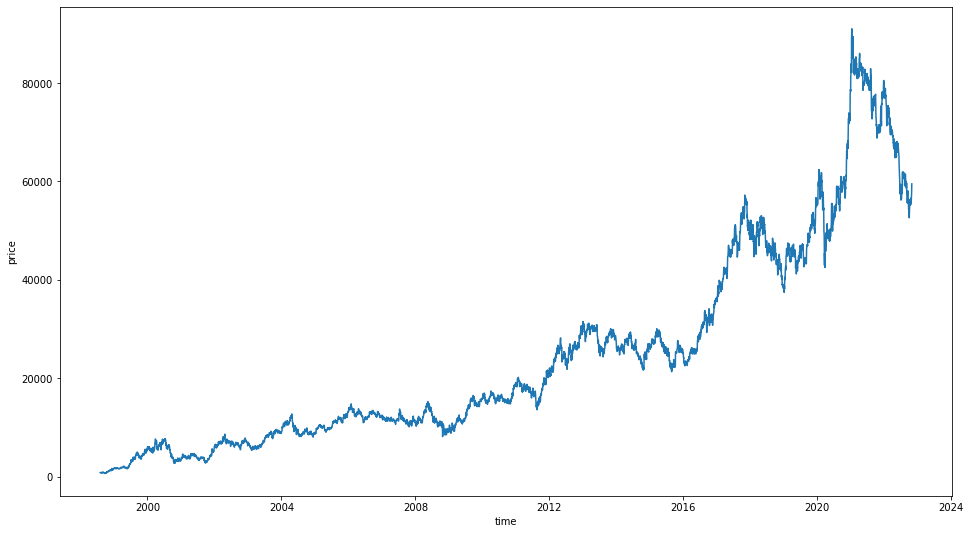

In [17]:
plt.figure(figsize=(16,9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

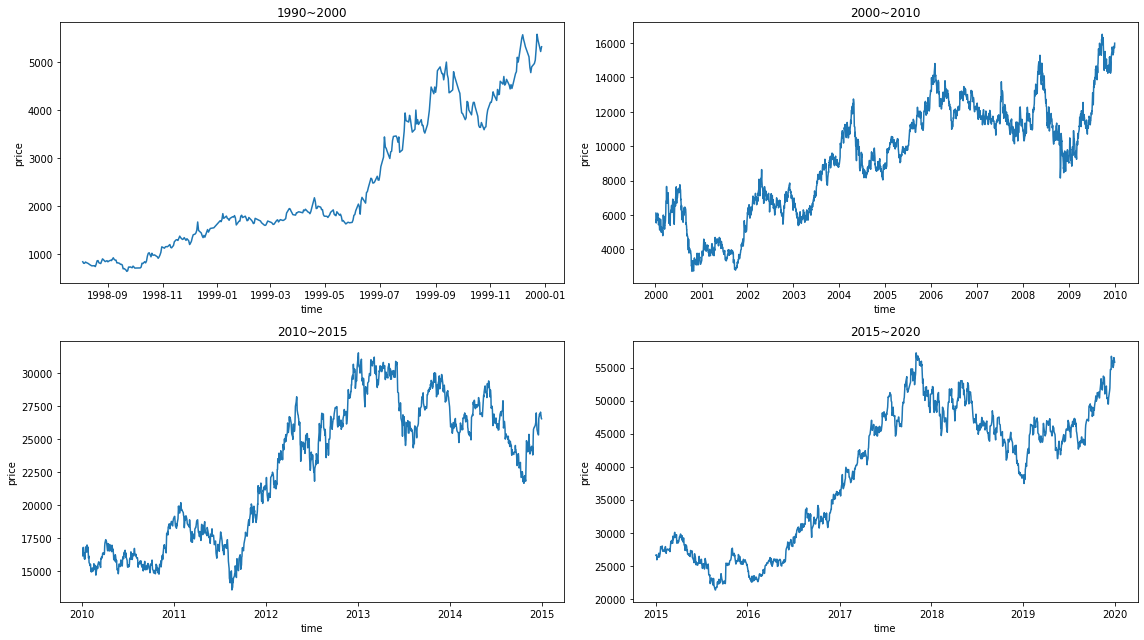

In [20]:
time_steps=[['1990','2000'],
            ['2000','2010'],
            ['2010','2015'],
            ['2015','2020']]

fig, axes = plt.subplots(2,2)
fig.set_size_inches(16,9)
for i in range(4):
  ax = axes[i//2, i%2]
  df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
  sns.lineplot(y=df['Close'], x=df.index, ax=ax)
  ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
  ax.set_xlabel('time')
  ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)** 진행


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open','High','Low','Close','Volume']

scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.00900332, 0.00875   , 0.00905028, 0.00221332, 0.0030504 ],
       [0.0092691 , 0.00870868, 0.00883799, 0.00185919, 0.00467764],
       [0.00871539, 0.00849174, 0.00877095, 0.00185919, 0.00301674],
       ...,
       [0.63122924, 0.6053719 , 0.63687151, 0.63148226, 0.19274072],
       [0.64230343, 0.61570248, 0.64469274, 0.65029548, 0.23060402],
       [0.66112957, 0.62086777, 0.65810056, 0.65140214, 0.23951558]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성

**시간 순으로 정렬**, datetime index는 제외



In [23]:
df = pd.DataFrame(scaled, columns=scale_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6000 non-null   float64
 1   High    6000 non-null   float64
 2   Low     6000 non-null   float64
 3   Close   6000 non-null   float64
 4   Volume  6000 non-null   float64
dtypes: float64(5)
memory usage: 234.5 KB


## train / test 분할

In [24]:
from sklearn.model_selection import train_test_split as tts

In [27]:
x_train, x_test, y_train, y_test = tts(df.drop('Close',1),df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [28]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [29]:
x_test

,Open,High,Low,Volume
4800,0.575858,0.537603,0.575419,0.001800
4801,0.573865,0.538223,0.577207,0.001941
4802,0.576966,0.538223,0.570950,0.002510
4803,0.568328,0.540083,0.570503,0.004498
4804,0.567442,0.531818,0.564469,0.003306
...,...,...,...,...
5995,0.610188,0.581612,0.615642,0.126858
5996,0.631229,0.594008,0.633520,0.187634
5997,0.631229,0.605372,0.636872,0.192741
5998,0.642303,0.615702,0.644693,0.230604


In [30]:
x_train

,Open,High,Low,Volume
0,0.009003,0.008750,0.009050,0.003050
1,0.009269,0.008709,0.008838,0.004678
2,0.008715,0.008492,0.008771,0.003017
3,0.008959,0.008688,0.009039,0.004347
4,0.009380,0.008750,0.009106,0.001884
...,...,...,...,...
4795,0.563012,0.530372,0.558883,0.003292
4796,0.560354,0.529959,0.561788,0.002066
4797,0.567663,0.532645,0.558883,0.002412
4798,0.554153,0.526653,0.558883,0.002451


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [31]:
import tensorflow as tf

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter 정의

In [33]:
WINDOW_SIZE = 20
BATCH_SIZE = 32

In [34]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [35]:
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    Conv1D(filters=32, kernel_size=5,
           padding='causal',
           activation='relu',
           input_shape=[WINDOW_SIZE,1]),
    LSTM(16,activation='tanh'),
    Dense(16, activation='relu'),
    Dense(1)
])

In [39]:
loss = Huber()
optimizer = Adam(0.005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [40]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [41]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 13s 7ms/step - loss: 6.7769e-05 - mse: 1.3554e-04
Epoch 1: val_loss improved from inf to 0.00045, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 14s 13ms/step - loss: 6.7769e-05 - mse: 1.3554e-04 - val_loss: 4.5021e-04 - val_mse: 9.0042e-04
Epoch 2/50
149/150 [============================>.] - ETA: 0s - loss: 2.5048e-05 - mse: 5.0096e-05
Epoch 2: val_loss did not improve from 0.00045
150/150 [==============================] - 1s 8ms/step - loss: 2.5074e-05 - mse: 5.0148e-05 - val_loss: 7.7322e-04 - val_mse: 0.0015
Epoch 3/50
147/150 [============================>.] - ETA: 0s - loss: 3.1528e-05 - mse: 6.3056e-05
Epoch 3: val_loss did not improve from 0.00045
150/150 [==============================] - 1s 9ms/step - loss: 3.2061e-05 - mse: 6.4123e-05 - val_loss: 7.4124e-04 - val_mse: 0.0015
Epoch 4/50
142/150 [===========================>..] - ETA: 0s - loss: 3.2778e-05 - mse: 6.5556e-05
Epoch 4: val_loss did not improve from 

저장한 ModelCheckpoint 로드

In [42]:
model.load_weights(filename)

`test_data`를 활용하여 예측 진행

In [43]:
pred = model.predict(test_data)

37/37 [==============================] - 1s 5ms/step


In [44]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

### 시각화 코드 

y_test 데이터에 **[20:]**으로 슬라이싱

∵ 예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 **앞의 20일은 예측하지 않음**

∴ 20번 째 index와 비교하면 더욱 정확

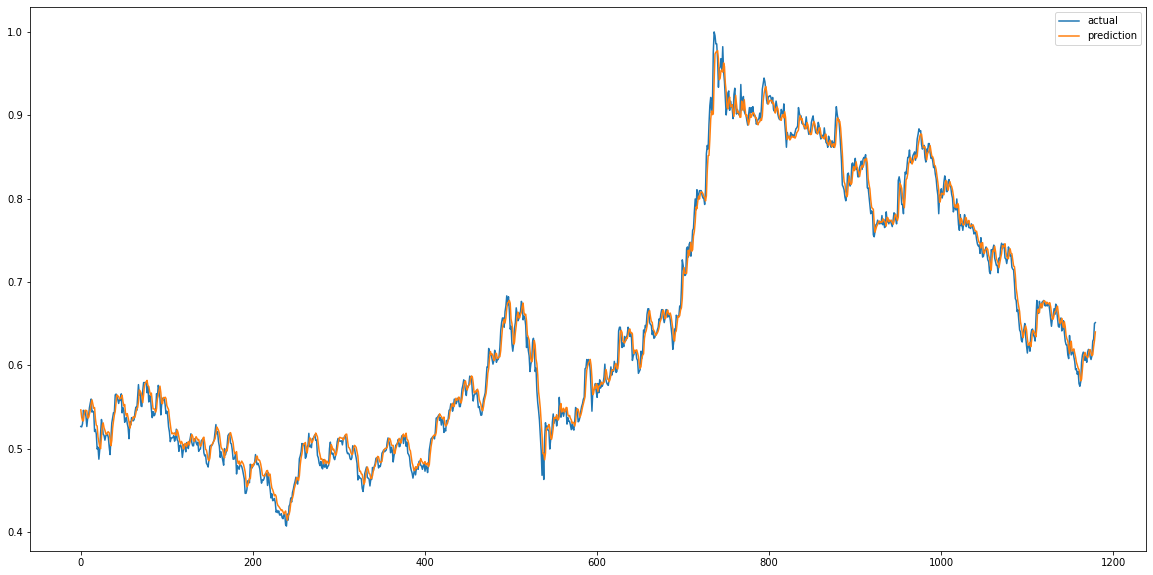

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()